# Préparation du Notebook

## Installation et importations des librairies

In [ ]:
pip install scikeras

  Using cached keras-3.3.2-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.2 which is incompatible.


In [ ]:
!pip install tensorflow

  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.2
    Uninstalling keras-3.3.2:
      Successfully uninstalled keras-3.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib.image as mpimg
import os
import cv2
import torch
import re
import string
import logging
import time

import spacy
from tqdm import tqdm
import tensorflow as tf

from PIL import Image

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy

from scikeras.wrappers import KerasClassifier

import optuna


from google.colab import files, drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/df_img.csv'
df = pd.read_csv(path)

# Aperçu du jeu de données

In [ ]:
df

,image_path,image,category_product
0,/content/drive/My Drive/Data/Flipkart/Images/0...,0c4718ae90f2889b7021a99ee1cc106c.jpg,kitchen dining
1,/content/drive/My Drive/Data/Flipkart/Images/0...,0c70a580d96e50966130e2885d8c3505.jpg,kitchen dining
2,/content/drive/My Drive/Data/Flipkart/Images/0...,0ca8e323551dd7107ef57ef7c3e77aee.jpg,kitchen dining
3,/content/drive/My Drive/Data/Flipkart/Images/0...,0d02f4703fde00645704e15bba23e77d.jpg,computers
4,/content/drive/My Drive/Data/Flipkart/Images/0...,0d3e1dc0d38be59e9927e47f152e48aa.jpg,kitchen dining
...,...,...,...
1045,/content/drive/My Drive/Data/Flipkart/Images/0...,0b793c1727ef52285a25dedf8b86626b.jpg,beauty and personal care
1046,/content/drive/My Drive/Data/Flipkart/Images/0...,0b852704f2002f8865a68818ad4951da.jpg,kitchen dining
1047,/content/drive/My Drive/Data/Flipkart/Images/0...,0b8c4bc35aee94af356cb1fd2dfa0219.jpg,kitchen dining
1048,/content/drive/My Drive/Data/Flipkart/Images/0...,0bb0f7b7a3075f4b9459121abe2185fa.jpg,home decor festive needs


## Rappels des catégories

In [ ]:
df['category_product'].nunique()

7

In [ ]:
df['category_product'].value_counts()

category_product
kitchen dining              150
computers                   150
watches                     150
beauty and personal care    150
home furnishing             150
home decor festive needs    150
baby care                   150
Name: count, dtype: int64

# Préparation des données

In [ ]:
# Augmentation de la limite par défaut
Image.MAX_IMAGE_PIXELS = None

In [ ]:
# Chargement, préparation de X  (images)

def image_prep_fct(df):
    base_image_path = '/content/drive/My Drive/Flipkart/Images'

    prepared_images = []
    for image_name in df['image']:
        image_path = os.path.join(base_image_path, image_name)

        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(df)
X = images_np
print(X.shape)

(1050, 224, 224, 3)


In [ ]:
# Préparation y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['category_product'])
y = to_categorical(y_encoded)

print(y.shape)
print(y)

(1050, 7)
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Division du jeu de données ( stratify + radom_state = contre la fuite d'information)

X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("La forme de X_train est :", X_train.shape)
print("La forme de X_val est :", X_val.shape)
print("La forme de X_test est :", X_val.shape)

La forme de X_train est : (735, 224, 224, 3)
La forme de X_val est : (157, 224, 224, 3)
La forme de X_test est : (157, 224, 224, 3)


# Tests des Modèles

##  Perceptron Multicouche Entièrement Connecté

Un MLP est un réseau de neurones avec une ou plusieurs couches cachées entre
la couche d'entrée et la couche de sortie. Chaque neurone dans une couche est
connecté à tous les neurones de la couche suivante, permettant au réseau
d'apprendre des représentations complexes des données. L'apprentissage se fait
par rétropropagation et descente de gradient pour ajuster les poids du réseau.

In [ ]:
# Initiation du modèle MLP simple - Modele de référence

model_mlp = Sequential()

model_mlp.add(Flatten(input_shape=(224, 224, 3)))

model_mlp.add(Dense(128))
model_mlp.add(LeakyReLU(alpha=0.01))
model_mlp.add(BatchNormalization())

model_mlp.add(Dense(64))
model_mlp.add(LeakyReLU(alpha=0.01))
model_mlp.add(BatchNormalization())

model_mlp.add(Dense(7, activation='softmax'))
model_mlp.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_mlp.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                        

In [ ]:
# Entraînement du modèle avec calcule du temps d'exécution
start_time = time.time()

model_mlp.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

end_time = time.time()
elapsed_time = end_time - start_time
print("")
print(f"Temps écoulé pour l'entraînement: {elapsed_time:.2f} secondes")

Epoch 1/10
23/23 [==============================] - 6s 54ms/step - loss: 1.9840 - accuracy: 0.2939 - val_loss: 4.4281 - val_accuracy: 0.3248
Epoch 2/10
23/23 [==============================] - 1s 31ms/step - loss: 1.3767 - accuracy: 0.5116 - val_loss: 2.7687 - val_accuracy: 0.3439
Epoch 3/10
23/23 [==============================] - 1s 31ms/step - loss: 1.2270 - accuracy: 0.5973 - val_loss: 2.0505 - val_accuracy: 0.4204
Epoch 4/10
23/23 [==============================] - 1s 30ms/step - loss: 1.0191 - accuracy: 0.6680 - val_loss: 1.6285 - val_accuracy: 0.4777
Epoch 5/10
23/23 [==============================] - 1s 27ms/step - loss: 0.9302 - accuracy: 0.7034 - val_loss: 1.4794 - val_accuracy: 0.5096
Epoch 6/10
23/23 [==============================] - 1s 26ms/step - loss: 0.7721 - accuracy: 0.7728 - val_loss: 1.5451 - val_accuracy: 0.4904
Epoch 7/10
23/23 [==============================] - 1s 27ms/step - loss: 0.6984 - accuracy: 0.7959 - val_loss: 1.5723 - val_accuracy: 0.4777
Epoch 8/10
23

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss_mlp, test_accuracy_mlp = model_mlp.evaluate(X_test, y_test)
print("")
print(f"Score du test : test_loss = {test_loss_mlp:.4f}, test_accuracy = {test_accuracy_mlp:.4f}")

5/5 [==============================] - 0s 17ms/step - loss: 1.6739 - accuracy: 0.4810

Score du test : test_loss = 1.6739, test_accuracy = 0.4810


In [ ]:
y_pred = model_mlp.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_true, y_pred_classes))

5/5 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.44      0.30      0.36        23
           1       0.75      0.41      0.53        22
           2       0.29      0.78      0.42        23
           3       0.46      0.26      0.33        23
           4       0.48      0.43      0.45        23
           5       0.72      0.59      0.65        22
           6       0.81      0.59      0.68        22

    accuracy                           0.48       158
   macro avg       0.56      0.48      0.49       158
weighted avg       0.56      0.48      0.49       158



In [ ]:
# Matrice de confusion
print(confusion_matrix(y_true, y_pred_classes))

[[ 7  0  9  2  3  1  1]
 [ 1  9  7  1  3  1  0]
 [ 0  1 18  2  1  0  1]
 [ 2  0 10  6  3  2  0]
 [ 4  2  4  1 10  1  1]
 [ 0  0  7  1  1 13  0]
 [ 2  0  7  0  0  0 13]]


Le modèle MLP a atteint une précision de test de 48.10%, ce qui indique une
performance modeste. Les résultats montrent une variation significative dans
la précision, le rappel et le score F1 entre les différentes classes, avec
des performances particulièrement faibles pour la classe 0 et des résultats
meilleurs pour les classes 1 et 6.

## CNN - Réseau neuronal convolutif

Un CNN est un type de réseau de neurones profond spécialement conçu pour
traiter des données structurées en grille, comme les images. Il se compose
de couches convolutives qui filtrent les données d'entrée pour en extraire
des caractéristiques, suivies de couches de pooling qui réduisent la
dimensionnalité.

In [ ]:
# Initiation du modèle CNN
model_cnn = Sequential()

# Couche de convolution et max pooling 1
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

# Couche de convolution et max pooling 2
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

# Couche de convolution et max pooling 3
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(0.25))

# Aplatir les sorties pour les connecter à des couches denses
model_cnn.add(Flatten())

# Couche dense avec régularisation par dropout
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))

# Couche de sortie
model_cnn.add(Dense(7, activation='softmax'))

# Compilation du modèle
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_3 (Bat  (None, 109, 109, 64)     

In [ ]:
# Entraînement du modèle avec calcule du temps d'execution

start_time = time.time()

model_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

end_time = time.time()
elapsed_time = end_time - start_time
print("")
print(f"Temps écoulé pour l'entraînement: {elapsed_time:.2f} secondes")

Epoch 1/10
23/23 [==============================] - 13s 285ms/step - loss: 2.1800 - accuracy: 0.3565 - val_loss: 6.1975 - val_accuracy: 0.3758
Epoch 2/10
23/23 [==============================] - 3s 132ms/step - loss: 1.4644 - accuracy: 0.5320 - val_loss: 3.4808 - val_accuracy: 0.4013
Epoch 3/10
23/23 [==============================] - 3s 132ms/step - loss: 1.1154 - accuracy: 0.6422 - val_loss: 1.8216 - val_accuracy: 0.4650
Epoch 4/10
23/23 [==============================] - 3s 147ms/step - loss: 1.0427 - accuracy: 0.6544 - val_loss: 1.7283 - val_accuracy: 0.4013
Epoch 5/10
23/23 [==============================] - 4s 155ms/step - loss: 0.8050 - accuracy: 0.7306 - val_loss: 1.2434 - val_accuracy: 0.5924
Epoch 6/10
23/23 [==============================] - 3s 139ms/step - loss: 0.6445 - accuracy: 0.7918 - val_loss: 1.4855 - val_accuracy: 0.5541
Epoch 7/10
23/23 [==============================] - 3s 143ms/step - loss: 0.5453 - accuracy: 0.8218 - val_loss: 1.5809 - val_accuracy: 0.5287
Epoch

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test)
print("")
print(f"Score du test : test_loss = {test_loss_cnn:.4f}, test_accuracy = {test_accuracy_cnn:.4f}")

5/5 [==============================] - 1s 168ms/step - loss: 1.4229 - accuracy: 0.5570

Score du test : test_loss = 1.4229, test_accuracy = 0.5570


In [ ]:
y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_true, y_pred_classes))

5/5 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.35      0.61      0.44        23
           1       0.88      0.32      0.47        22
           2       0.58      0.78      0.67        23
           3       0.48      0.65      0.56        23
           4       0.42      0.35      0.38        23
           5       0.83      0.45      0.59        22
           6       0.94      0.73      0.82        22

    accuracy                           0.56       158
   macro avg       0.64      0.56      0.56       158
weighted avg       0.64      0.56      0.56       158



In [ ]:
# Matrice de confusion
print(confusion_matrix(y_true, y_pred_classes))

[[14  0  3  1  5  0  0]
 [ 8  7  1  4  1  1  0]
 [ 3  0 18  2  0  0  0]
 [ 2  0  1 15  4  1  0]
 [ 9  0  1  4  8  0  1]
 [ 1  0  5  5  1 10  0]
 [ 3  1  2  0  0  0 16]]


Le CNN a obtenu une précision de test de 55.70%, surpassant le MLP précédent.
Les scores de précision et de rappel varient considérablement entre les classes,
avec des performances élevées pour les classes 1 et 6, mais des résultats
inférieurs pour la classe 0. La matrice de confusion indique des confusions
entre certaines classes,

## CNN VGG16 - ImageNet


VGG16 est un CNN pré-entraîné sur ImageNet, utilisé pour le transfer learning
dans la classification d'images. Il permet un apprentissage rapide et efficace
sur de nouveaux jeux de données en exploitant des caractéristiques visuelles
générales déjà apprises.

In [ ]:
# Chargement de VGG16 pré-entraîné sans les couches entièrement connectées
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Gele des couches du modèle de base pour ne pas les réentraîner
for layer in vgg16_base.layers:
    layer.trainable = False

# Initiation du modèle CNN avec VGG16 comme base
model_vgg = Sequential()

# Ajout de VGG16 comme couche de base
model_vgg.add(vgg16_base)

# Ajout des couches personnalisées
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(7, activation='softmax'))

# Compilation du modèle
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

# Callback pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               3211392   
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 7)                 903       
                                                      

In [ ]:
# Entraînement du modele avec calcule du temps d'exécution

start_time = time.time()

model_vgg.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

end_time = time.time()
elapsed_time = end_time - start_time
print("")
print(f"Temps écoulé pour l'entraînement: {elapsed_time:.2f} secondes")

Epoch 1/10
23/23 [==============================] - 29s 913ms/step - loss: 1.6309 - accuracy: 0.5170 - val_loss: 1.4247 - val_accuracy: 0.6688
Epoch 2/10
23/23 [==============================] - 4s 159ms/step - loss: 0.4194 - accuracy: 0.8612 - val_loss: 0.8557 - val_accuracy: 0.7516
Epoch 3/10
23/23 [==============================] - 4s 158ms/step - loss: 0.2518 - accuracy: 0.9279 - val_loss: 0.6913 - val_accuracy: 0.8280
Epoch 4/10
23/23 [==============================] - 4s 158ms/step - loss: 0.1695 - accuracy: 0.9524 - val_loss: 0.6686 - val_accuracy: 0.8344
Epoch 5/10
23/23 [==============================] - 5s 201ms/step - loss: 0.1151 - accuracy: 0.9687 - val_loss: 0.6307 - val_accuracy: 0.8408
Epoch 6/10
23/23 [==============================] - 4s 157ms/step - loss: 0.0786 - accuracy: 0.9918 - val_loss: 0.6123 - val_accuracy: 0.8408
Epoch 7/10
23/23 [==============================] - 4s 154ms/step - loss: 0.0729 - accuracy: 0.9837 - val_loss: 0.5878 - val_accuracy: 0.8535
Epoch

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss_vgg, test_accuracy_vgg = model_vgg.evaluate(X_test, y_test)
print("")
print(f"Score du test : test_loss = {test_loss_vgg:.4f}, test_accuracy = {test_accuracy_vgg:.4f}")

5/5 [==============================] - 7s 2s/step - loss: 0.6503 - accuracy: 0.8101

Score du test : test_loss = 0.6503, test_accuracy = 0.8101


In [ ]:
y_pred = model_vgg.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_true, y_pred_classes))

5/5 [==============================] - 1s 129ms/step
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.89      0.73      0.80        22
           2       0.81      0.91      0.86        23
           3       0.68      0.74      0.71        23
           4       0.77      0.87      0.82        23
           5       0.86      0.82      0.84        22
           6       0.88      0.95      0.91        22

    accuracy                           0.81       158
   macro avg       0.82      0.81      0.81       158
weighted avg       0.81      0.81      0.81       158



In [ ]:
# Matrice de confusion
print(confusion_matrix(y_true, y_pred_classes))

[[15  1  0  2  5  0  0]
 [ 0 16  0  3  0  2  1]
 [ 0  1 21  0  0  0  1]
 [ 0  0  3 17  1  1  1]
 [ 3  0  0  0 20  0  0]
 [ 0  0  1  3  0 18  0]
 [ 0  0  1  0  0  0 21]]


Le VGG16 pré-entraîné a démontré une excellente précision de test de 81.01%,
reflétant la puissance du transfer learning pour la classification d'images.
Les scores élevés de précision, de rappel et de F1-score à travers les classes
indiquent que le modèle a bien généralisé sur le nouveau jeu de données. La
matrice de confusion montre une bonne distinction entre les classes, avec
quelques confusions mineures.

In [ ]:
# Tableau des résultats

result = {
    "Modèles": [
        "MLP", "CNN",
        "VGG 16 ImageNet"],

    "Test Loss": [
        test_loss_mlp, test_loss_cnn,
        test_loss_vgg],

    "Test Accuracy": [
        test_accuracy_mlp, test_accuracy_cnn,
        test_accuracy_vgg]
}


df_performance = pd.DataFrame(result)
df_performance

,Modèles,Test Loss,Test Accurancy
0,MLP,1.673886,0.481013
1,CNN,1.422901,0.556962
2,VGG 16 ImageNet,0.650294,0.810127


## Hyperparamètre - Taux d'apprentissage

**Recherche d'Hyperparamètres:**

La recherche d'hyperparamètres consiste à trouver la combinaison optimale
d'hyperparamètres qui améliore les performances d'un modèle d'apprentissage
automatique. Une recherche manuelle implique d'ajuster et de tester
systématiquement ces hyperparamètres jusqu'à obtenir les meilleurs résultats.

**Learning Rate:**

Le learning rate est un hyperparamètre crucial qui détermine la taille des
pas effectués lors de la mise à jour des poids du réseau pendant
l'apprentissage. Un learning rate trop élevé peut conduire à un
apprentissage instable, tandis qu'un taux trop faible peut rendre
l'apprentissage très lent et potentiellement aboutir à un minimum local.

In [ ]:
def create_model(trial):
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in vgg16_base.layers:
        layer.trainable = False

    model = Sequential([
        vgg16_base,
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def objective(trial):
    model = create_model(trial)
    sample_size = min(500, X_train.shape[0])
    subset_index = np.random.choice(X_train.shape[0], sample_size, replace=False)
    X_subset = X_train[subset_index]
    y_subset = y_train[subset_index]

    # Entraînement avec un nombre réduit d'époques et un sous-ensemble de données
    model.fit(X_subset, y_subset, validation_split=0.1, epochs=10, batch_size=32, verbose=0)

    # Évaluation sur le jeu de test
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Meilleur taux d'apprentissage:", study.best_trial.params['lr'])

[I 2024-04-23 06:46:25,830] A new study created in memory with name: no-name-dfd170f9-69f6-4013-a73c-1fc0018993af
[I 2024-04-23 06:47:09,823] Trial 0 finished with value: 0.7341772317886353 and parameters: {'lr': 3.0178075865291915e-05}. Best is trial 0 with value: 0.7341772317886353.
[I 2024-04-23 06:47:54,688] Trial 1 finished with value: 0.8354430198669434 and parameters: {'lr': 0.013092179865461146}. Best is trial 1 with value: 0.8354430198669434.
[I 2024-04-23 06:48:18,934] Trial 2 finished with value: 0.7911392450332642 and parameters: {'lr': 0.08668465921889472}. Best is trial 1 with value: 0.8354430198669434.
[I 2024-04-23 06:49:03,016] Trial 3 finished with value: 0.8164557218551636 and parameters: {'lr': 0.0009738532399991537}. Best is trial 1 with value: 0.8354430198669434.
[I 2024-04-23 06:49:47,639] Trial 4 finished with value: 0.746835470199585 and parameters: {'lr': 2.5687448530067955e-05}. Best is trial 1 with value: 0.8354430198669434.


Meilleur taux d'apprentissage: 0.013092179865461146


## Data Augmentation

La data augmentation est une technique pour augmenter la diversité des données
d'entraînement sans collecter de nouveaux échantillons. Elle implique
l'application de transformations comme la rotation, le zoom, le décalage ou
le retournement sur les images existantes. Cela aide à prévenir le surajustement
et améliore la généralisation du modèle sur des données non vues.

In [ ]:
df['new_image_path'] = df['image_path'].apply(lambda x: os.path.basename(x))

In [ ]:
# Meilleur taux d'apprentissage
best_lr = study.best_trial.params['lr']


# Configuration de l'augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Création du générateur de données d'entraînement
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/drive/My Drive/Flipkart/Images',
    x_col='new_image_path',
    y_col='category_product',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'

)

# Compilation du modèle avec le meilleur taux d'apprentissage
model_vgg.compile(optimizer=Adam(learning_rate=best_lr), loss='categorical_crossentropy', metrics=['accuracy'])

Found 1050 validated image filenames belonging to 7 classes.


In [ ]:
# Entraînement du modèle sans augmentation des données
history_no_aug = model_vgg.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Entraînement du modèle avec augmentation des données
history_aug = model_vgg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
23/23 [==============================] - 6s 188ms/step - loss: 0.8815 - accuracy: 0.7293 - val_loss: 1.1124 - val_accuracy: 0.8217
Epoch 2/10
23/23 [==============================] - 4s 159ms/step - loss: 0.3572 - accuracy: 0.8857 - val_loss: 0.8003 - val_accuracy: 0.8344
Epoch 3/10
23/23 [==============================] - 4s 159ms/step - loss: 0.1595 - accuracy: 0.9592 - val_loss: 0.6659 - val_accuracy: 0.8344
Epoch 4/10
23/23 [==============================] - 4s 160ms/step - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.7538 - val_accuracy: 0.8471
Epoch 5/10
23/23 [==============================] - 4s 193ms/step - loss: 0.0502 - accuracy: 0.9864 - val_loss: 0.7450 - val_accuracy: 0.8344
Epoch 6/10
23/23 [==============================] - 4s 161ms/step - loss: 0.0341 - accuracy: 0.9905 - val_loss: 0.6963 - val_accuracy: 0.8535
Epoch 7/10
23/23 [==============================] - 4s 160ms/step - loss: 0.0255 - accuracy: 0.9918 - val_loss: 0.6851 - val_accuracy: 0.8408
Epoch 

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss_vgg_aug, test_accuracy_vgg_aug =  model_vgg.evaluate(X_test, y_test)
print(f"Score du test : test_loss = {test_loss_vgg_aug:.4f}, test_accuracy = {test_accuracy_vgg_aug:.4f}")

5/5 [==============================] - 1s 124ms/step - loss: 1.0345 - accuracy: 0.9114
Score du test : test_loss = 1.0345, test_accuracy = 0.9114


In [ ]:
y_pred = model_vgg.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_true, y_pred_classes))

5/5 [==============================] - 1s 121ms/step
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        23
           1       0.95      0.82      0.88        22
           2       0.85      1.00      0.92        23
           3       0.92      1.00      0.96        23
           4       0.87      0.87      0.87        23
           5       0.91      0.95      0.93        22
           6       1.00      1.00      1.00        22

    accuracy                           0.91       158
   macro avg       0.91      0.91      0.91       158
weighted avg       0.91      0.91      0.91       158



In [ ]:
# Matrice de confusion
print(confusion_matrix(y_true, y_pred_classes))

[[17  1  1  0  3  1  0]
 [ 0 18  1  2  0  1  0]
 [ 0  0 23  0  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 2  0  1  0 20  0  0]
 [ 0  0  1  0  0 21  0]
 [ 0  0  0  0  0  0 22]]


In [ ]:
# Fonction pour tracer l'historique de l'entraînement
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(15, 5))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])

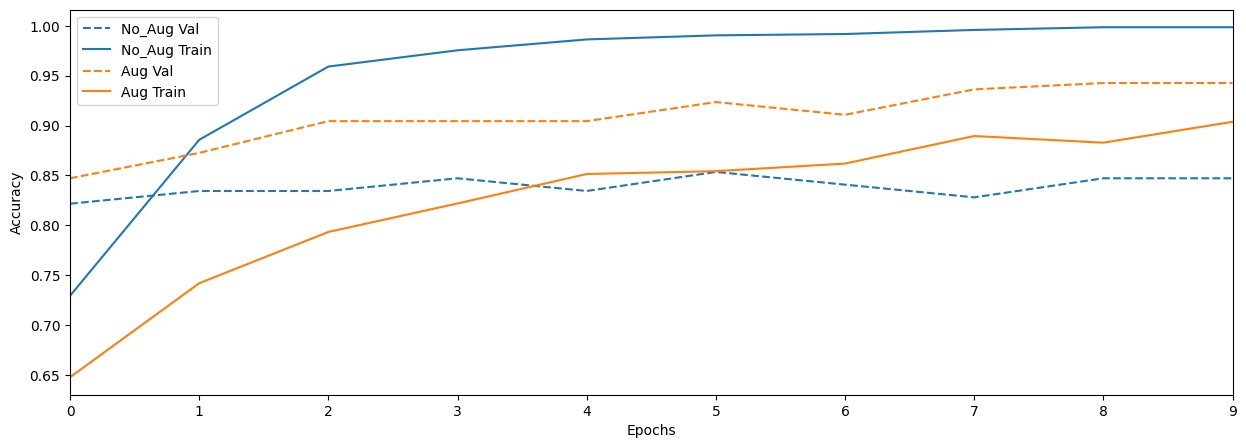

In [ ]:
# Graphique
plot_history([('no_aug', history_no_aug), ('aug', history_aug)])
plt.show()

In [ ]:
# Tableau des résultats

result = {
    "Modèles": [
        "MLP", "CNN",
        "VGG 16 ImageNet",
        "VGG 16 ImageNet + Data Aug"],

    "Test Loss": [
        test_loss_mlp, test_loss_cnn,
        test_loss_vgg,test_loss_vgg_aug],

    "Test Accuracy": [
        test_accuracy_mlp, test_accuracy_cnn,
        test_accuracy_vgg,test_accuracy_vgg_aug]
}


df_performance = pd.DataFrame(result)
df_performance

,Modèles,Test Loss,Test Accurancy
0,MLP,1.673886,0.481013
1,CNN,1.422901,0.556962
2,VGG 16 ImageNet,0.650294,0.810127
3,VGG 16 ImageNet + Data Aug,1.034525,0.911392


Les résultats montrent une progression nette dans les performances des modèles
testés.  
- Le MLP a montré une précision de base, tandis que le CNN a légèrement
amélioré cette performance.  
- Le VGG16 pré-entraîné sur ImageNet a fait un bond
significatif en précision, démontrant l'efficacité du transfer learning.  
- Cependant, c'est le VGG16 combiné avec la data augmentation qui a obtenu les
meilleurs résultats, avec une précision de test impressionnante de 91.14%.   

Cela souligne l'importance de la data augmentation pour améliorer la
généralisation du modèle, en particulier lorsqu'il est combiné avec des
modèles pré-entraînés puissants. La matrice de confusion pour ce dernier
modèle indique une excellente capacité à distinguer entre les classes,
avec des scores élevés de précision et de rappel.  

En conclusion, le VGG16
avec data augmentation se révèle être le plus performant pour la tâche de
classification d'images dans cette série d'expériences.